Link referred
https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import glob

from sklearn.preprocessing import RobustScaler
from scipy import stats
import numpy as np
import h5py
from tensorflow.keras.models import model_from_json

In [6]:
def get_raw_data(xfile, yfile):
    check_df_y = pd.read_csv(yfile)
    check_df_x = pd.read_csv(xfile)
    
    new_labels = []
    for i in check_df_y.iterrows():
        new_labels += [i[1][0]] * 4
    
    new_labels = pd.DataFrame(new_labels)
    diff = check_df_x.shape[0] - new_labels.shape[0]
    check_df_x = check_df_x.iloc[:-diff,:]
    
    return check_df_x, new_labels

In [7]:
def compose_series_data(x_files, y_files, time_steps = 40, step = 1):
    all_x = []
    all_y = []
    # create a series from all the subjects
    for i in range(len(y_files)):
        # get x-y balanced data, basically removed the extra values in x
        X, y = get_raw_data(x_files[i], y_files[i])
        
        # scale data
        X = scale_data(X, list(X.columns.values))
        # create series data for this file
        X, y = create_dataset_with_mode_labels(X, y, time_steps = time_steps, step = step)
        
        all_x.append(X)
        all_y.append(y)
    return np.concatenate(all_x), np.concatenate(all_y)

In [8]:
def scale_data(df_data, scale_columns):
    scaler = RobustScaler()
    scaler = scaler.fit(df_data[scale_columns])

    df_data.loc[:, scale_columns] = scaler.transform(df_data[scale_columns].to_numpy())
    return df_data

In [9]:
def create_dataset_with_mode_labels(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [10]:
def create_dataset(X, label, time_steps = 40, step = 1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [8]:
all_y_files = sorted(glob.glob('Data/TrainingData/subject_???_??__y.csv'))
all_x_files = sorted(glob.glob('Data/TrainingData/subject_???_??__x.csv'))

test_y_files = [] #["Data/TrainingData/subject_002_03__y.csv", "Data/TrainingData/subject_001_04__y.csv"]
test_x_files = [] #["Data/TrainingData/subject_002_03__x.csv", "Data/TrainingData/subject_001_04__x.csv"]

val_y_files = [] # ["Data/TrainingData/subject_003_02__y.csv", "Data/TrainingData/subject_007_04__y.csv"]
val_x_files = [] # ["Data/TrainingData/subject_003_02__x.csv", "Data/TrainingData/subject_007_04__x.csv"]

# subtract the files that are in test and val
train_y_files = sorted(list(set(all_y_files) ^ set(test_y_files + val_y_files)))
train_x_files = sorted(list(set(all_x_files) ^ set(test_x_files + val_x_files)))

In [11]:
TIME_STEPS = 60
STEP = 1

In [11]:
X_train, y_train = compose_series_data(train_x_files, train_y_files, time_steps = TIME_STEPS, step = STEP)
# X_val, y_val = compose_series_data(val_x_files, val_y_files, time_steps = TIME_STEPS, step = STEP)
# X_test, y_test = compose_series_data(test_x_files, test_y_files, time_steps = TIME_STEPS, step = STEP)

print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
# print(X_test.shape, y_test.shape)


(1339796, 60, 6) (1339796, 1)


In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train.ravel())
print(class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

[0.33302644 6.08865338 4.60120062 1.62427079]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.3330264383712826,
 1: 6.0886533847160615,
 2: 4.6012006154184295,
 3: 1.624270785345392}

In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)
# y_val = enc.transform(y_val)

In [12]:
import tensorflow as tf
from tensorflow import keras

In [25]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
#     validation_split=0,
#     validation_data=(X_val,y_val),
    class_weight=class_weights,
    shuffle=False
)

  ...
    to  
  ['...']
Train on 1339796 samples
Epoch 1/20
1339796/1339796 [==============================] - 114s 85us/sample - loss: 1.1947 - acc: 0.3699
Epoch 2/20
1339796/1339796 [==============================] - 111s 83us/sample - loss: 0.5218 - acc: 0.6235
Epoch 3/20
1339796/1339796 [==============================] - 110s 82us/sample - loss: 0.4332 - acc: 0.6799
Epoch 4/20
1339796/1339796 [==============================] - 109s 81us/sample - loss: 0.3251 - acc: 0.7939
Epoch 5/20
1339796/1339796 [==============================] - 110s 82us/sample - loss: 0.2507 - acc: 0.8540
Epoch 6/20
1339796/1339796 [==============================] - ETA: 0s - loss: 0.2059 - acc: 0.878 - 108s 81us/sample - loss: 0.2058 - acc: 0.8782
Epoch 7/20
1339796/1339796 [==============================] - 106s 79us/sample - loss: 0.1765 - acc: 0.8992
Epoch 8/20
1339796/1339796 [==============================] - 108s 81us/sample - loss: 0.1608 - acc: 0.9102
Epoch 9/20
1339796/1339796 [====================

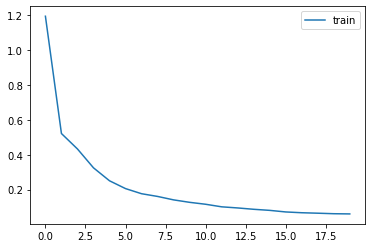

In [27]:
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [19]:
model.evaluate(X_test, y_test)

103624/103624 [==============================] - 30s 292us/sample - loss: 0.5089 - acc: 0.7793


[0.5088828856851019, 0.77931756]

In [17]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

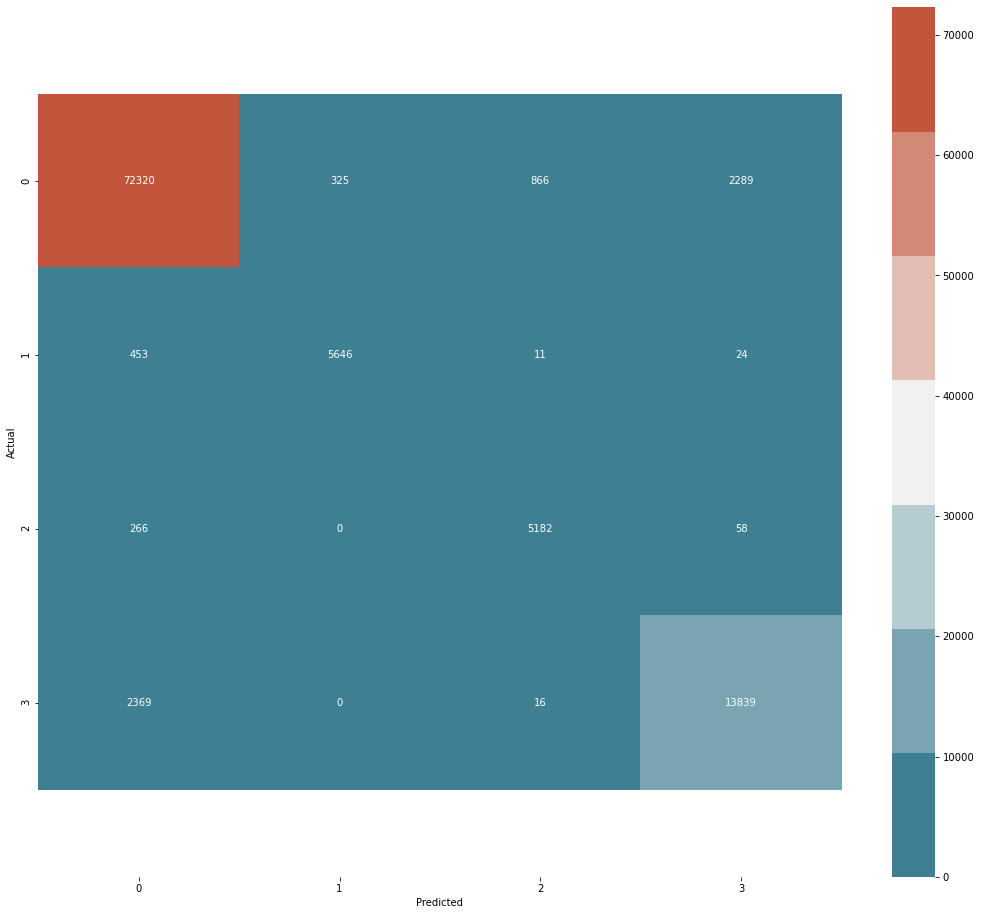

In [19]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [20]:
print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     75800
           1       0.95      0.92      0.93      6134
           2       0.85      0.94      0.89      5506
           3       0.85      0.85      0.85     16224

    accuracy                           0.94    103664
   macro avg       0.90      0.92      0.91    103664
weighted avg       0.94      0.94      0.94    103664



In [13]:
def save_model(model, name):
    model_json = model.to_json()
    with open("%s.json"%(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("%s.hdf5"%(name))

In [14]:
def get_model(name):
    json_file = open('%s.json'%(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("%s.hdf5"%(name))
    model = loaded_model
    return model

In [15]:
# save the model
# note the time steps
model_name = "model_BiLSTM_window_continuous_no_val_ts%d_s%d"%(TIME_STEPS, STEP)

In [31]:
save_model(model, model_name)